# Imports

In [299]:
import logging
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from brainflow import *
from keras import constraints, layers, optimizers
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from scipy import signal
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load Data

In [300]:
data_0 = pd.read_csv("../data/60s-l-0.csv")
data_1 = pd.read_csv("../data/60s-arm-flap.csv")

SCALE_FACTOR = (4500000) / 24 / (2**23 - 1)
FREQ = 250

# trim the first and last 5 seconds off the data
data_0 = data_0.iloc[5 * FREQ : -5 * FREQ, :]
data_1 = data_1.iloc[5 * FREQ : -5 * FREQ, :]

# scale the eeg columns (eeg1 - eeg8) by SCALE_FACTOR
eeg_cols = [f"eeg{i}" for i in range(1, 9)]
data_0[eeg_cols] = data_0[eeg_cols] * SCALE_FACTOR
data_1[eeg_cols] = data_1[eeg_cols] * SCALE_FACTOR

data = pd.concat([data_0, data_1])
data.head()

,sample,packet,eeg1,eeg2,eeg3,eeg4,eeg5,eeg6,eeg7,eeg8,...,other3,other4,other5,other6,other7,analog1,analog2,analog3,timestamp,marker
1250,1250,226.0,479.456089,808.791727,-999.518706,-890.343511,3976.856293,162.700392,-975.344538,-400.449769,...,80.0,30.0,128.0,2.0,64.0,0.0,0.0,0.0,1.676478e+09,0
1251,1251,227.0,480.861965,809.349281,-997.780097,-889.953323,3978.641865,163.546715,-967.924472,-394.095350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1252,1252,228.0,482.959787,811.613970,-997.053678,-890.076225,3979.265367,163.935904,-961.269294,-386.629321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1253,1253,229.0,481.597876,811.125360,-999.174981,-890.885578,3977.095102,162.627950,-968.572453,-393.160098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1254,1254,230.0,479.488563,808.964089,-999.854937,-890.640274,3976.815326,162.475572,-975.514402,-400.742535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0


# Preprocess Data

In [301]:
eeg_data = []
for i in range(1, 9):
    eeg_data.append(data[f"eeg{i}"][:])
eeg_data = np.array(eeg_data)

timestamps = data["timestamp"][:]
markers = data["marker"][:]

## Filters

In [302]:
NOTCH_SIZE = 3


def notch_filter(signal_data, notch_freq=60, notch_size=NOTCH_SIZE, fs=250):
    """Removes background noise at 60 hz (power lines)"""
    notch_freq_Hz = np.array([float(notch_freq)])
    fin = signal_data
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + notch_size * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), "bandstop")
        fin = signal_data = signal.lfilter(b, a, signal_data)
    return fin

In [303]:
FREQ_LOW = 13
FREQ_HIGH = 80


def bandpass(data, lowcut=FREQ_LOW, highcut=FREQ_HIGH, fs=250):
    """Smooths and reduces gain depending on specified frequency band"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype="band")
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [304]:
# Apply filters
for col in eeg_cols:
    data_filtered = notch_filter(data[col])
    data_filtered = bandpass(data_filtered)
    data[col] = data_filtered

data.head()

,sample,packet,eeg1,eeg2,eeg3,eeg4,eeg5,eeg6,eeg7,eeg8,...,other3,other4,other5,other6,other7,analog1,analog2,analog3,timestamp,marker
1250,1250,226.0,0.054824,0.086865,-0.094909,-0.087819,0.407193,0.018300,-0.083573,-0.025457,...,80.0,30.0,128.0,2.0,64.0,0.0,0.0,0.0,1.676478e+09,0
1251,1251,227.0,-11.036057,-20.026793,26.728838,22.921847,-99.064925,-3.319029,30.465858,15.155289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1252,1252,228.0,79.272787,131.946318,-159.738815,-143.420212,642.689317,26.966507,-149.107646,-56.633889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1253,1253,229.0,99.999574,168.023034,-205.810590,-183.796729,819.955579,33.603404,-197.170469,-78.320343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0
1254,1254,230.0,-13.419009,-22.194914,26.740987,23.994948,-108.265006,-4.589215,25.117646,9.405304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676478e+09,0


## Fourier Transforms

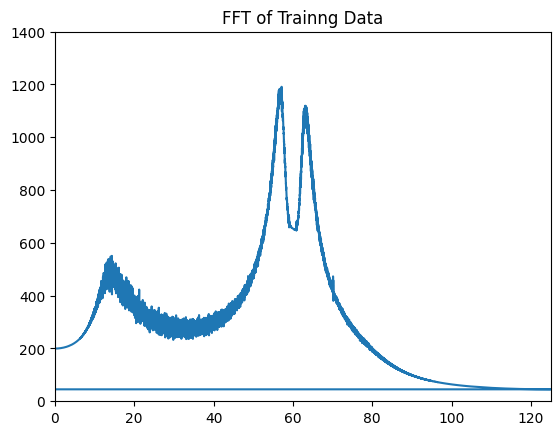

In [305]:
training_fourier = []

# Get frequency lists
training_freqs = np.fft.fftfreq(data["timestamp"].values.T.shape[-1], d=1 / FREQ)

# Get fourier transforms for each channel
for i in range(8):
    training_fourier.append(np.absolute(np.fft.fft(data[f"eeg{i+1}"].values.T)))

# Stack fourier transforms
training_stacked = np.stack(training_fourier, axis=1)

# Average fourier transforms
training_avg_fourier = np.mean(training_stacked, axis=1)

plt.plot(training_freqs, training_avg_fourier)
plt.xlim(0, 125)
plt.ylim(0, 1400)
plt.title("FFT of Trainng Data")
plt.show()

## Split data

In [306]:
# Time window (in seconds) to consider preceding each space press
window_size = 0.05  # 50 ms

# Uncertainty (in seconds) around each space press marker
space_buffer = 0.02

# Latency assumption (in seconds)
latency = 0.02

In [307]:
def get_processed_data(
    times,
    channels,
    markers,
    window_size=window_size,
    space_buffer=space_buffer,
    latency=latency,
    n_width=NOTCH_SIZE,
    freq_lowerbound=FREQ_LOW,
    freq_upperbound=FREQ_HIGH,
):
    # Define return arrays
    x_data = []
    y_data = []

    fs = FREQ

    # The number of indices to consider preceding each space press
    delta_i = int(fs * window_size)

    space_i = int(fs * space_buffer)

    lat_i = int(fs * latency)

    # Number of trainingtime samples to consider
    num_samples = len(times) - delta_i - 1

    # Get frequency list
    freqs = np.fft.fftfreq(times[0:delta_i].shape[-1], d=1 / fs)

    # Record indices of chosen frequencies
    relevant_freq = []
    relevant_freq_indices = []

    for i, f in enumerate(freqs):
        if freq_lowerbound <= f <= freq_upperbound:
            relevant_freq.append(f)
            relevant_freq_indices.append(i)

    for i in range(num_samples):
        # Define window data
        window_data = []

        # Define window end index
        window_end = i + delta_i

        # Record space press
        y_data.append(max(markers[window_end - 2 - lat_i : window_end + 1 - lat_i]))

        # Get fourier transforms for each channel
        for channel in channels:
            fourier_series = np.absolute(np.fft.fft(channel[i : i + delta_i]))
            window_data.append(
                fourier_series[relevant_freq_indices[0] : relevant_freq_indices[-1] + 1]
            )

        # Stack fourier transforms
        window_stack = np.stack(window_data, axis=1)

        # Average fourier transforms
        window_avg = np.mean(window_stack, axis=1)

        x_data.append(np.array(window_avg))

        del window_data

    return np.array(x_data), np.array(y_data), relevant_freq

Get training and validation data

In [308]:
x_data, y_data, freq_list = get_processed_data(timestamps, eeg_data, markers)
x_data.shape, y_data.shape, freq_list

/tmp/ipykernel_2879/983914191.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  freqs = np.fft.fftfreq(times[0:delta_i].shape[-1], d=1 / fs)
/tmp/ipykernel_2879/983914191.py:48: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_data.append(max(markers[window_end - 2 - lat_i : window_end + 1 - lat_i]))


((24971, 3), (24971,), [20.833333333333332, 41.666666666666664, 62.5])

In [309]:
# Split data into training and validation sets
x_train: np.ndarray
x_val: np.ndarray
y_train: np.ndarray
y_val: np.ndarray
x_train, x_val, y_train, y_val = train_test_split(  # type: ignore
    x_data, y_data, test_size=0.2, shuffle=True, random_state=42
)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((19976, 3, 1), (4995, 3, 1), (19976, 1), (4995, 1))

# Model

In [310]:
model = tf.keras.Sequential(
    [
        layers.Conv1D(64, 3, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Conv1D(64, 3, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        layers.AveragePooling1D(2),
        layers.Dropout(0.25),
        layers.Conv1D(128, 3, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        layers.AveragePooling1D(1),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(2),
        layers.Activation("softmax"),
    ]
)

In [311]:
# one hot encode target values
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [312]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [313]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    batch_size=32,
)

Epoch 1/25
625/625 [==============================] - 3s 3ms/step - loss: 0.1953 - accuracy: 0.9168 - val_loss: 0.1524 - val_accuracy: 0.9277
Epoch 2/25
625/625 [==============================] - 2s 3ms/step - loss: 0.1900 - accuracy: 0.9196 - val_loss: 0.1493 - val_accuracy: 0.9273
Epoch 3/25
625/625 [==============================] - 2s 3ms/step - loss: 0.1859 - accuracy: 0.9194 - val_loss: 0.1553 - val_accuracy: 0.9281
Epoch 4/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1829 - accuracy: 0.9212 - val_loss: 0.1494 - val_accuracy: 0.9273
Epoch 5/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1817 - accuracy: 0.9220 - val_loss: 0.1531 - val_accuracy: 0.9281
Epoch 6/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1778 - accuracy: 0.9235 - val_loss: 0.1479 - val_accuracy: 0.9275
Epoch 7/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1798 - accuracy: 0.9212 - val_loss: 0.1549 - val_accuracy: 0.9285
Epoch 

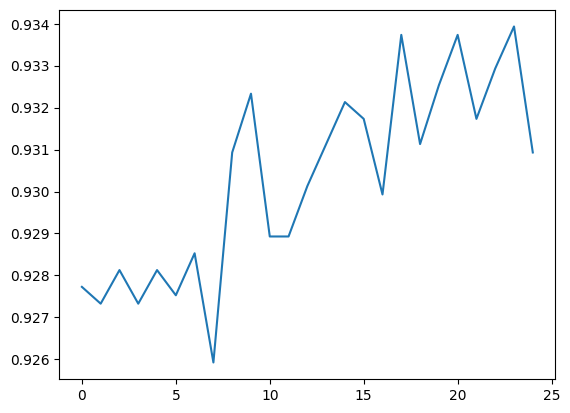

In [314]:
plt.plot(model.history.history["val_accuracy"])

In [315]:
y_pred = model(np.array(x_data))

In [316]:
pred_classes = np.argmax(y_pred, axis=1)
sum(pred_classes == y_data) / len(y_data)

0.928396940450923

In [317]:
print(confusion_matrix(y_data, pred_classes))

[[10945  1544]
 [  244 12238]]


In [318]:
print(classification_report(y_data, pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92     12489
           1       0.89      0.98      0.93     12482

    accuracy                           0.93     24971
   macro avg       0.93      0.93      0.93     24971
weighted avg       0.93      0.93      0.93     24971



## Test on Real Data

In [319]:
def load_data(fp):
    data = pd.read_csv(fp)
    SCALE_FACTOR = (4500000) / 24 / (2**23 - 1)
    FREQ = 250  # 250 samples per second

    # trim the first and last 5 seconds off the data
    data = data_0.iloc[5 * FREQ : -5 * FREQ, :]

    eeg_cols = [f"eeg{i}" for i in range(1, 9)]
    data[eeg_cols] = data[eeg_cols] * SCALE_FACTOR

    for col in eeg_cols:
        data_filtered = notch_filter(data[col])
        data_filtered = bandpass(data_filtered)
        data[col] = data_filtered

    eeg_data = np.array([data[f"eeg{i}"][:] for i in range(1, 9)])
    timestamps = data["timestamp"][:]
    markers = data["marker"][:]

    x_data, y_data, freq_list = get_processed_data(timestamps, eeg_data, markers)
    return x_data, y_data, freq_list


x_test, y_test, freq_list = load_data("../data/3-games-arm-flap.csv")

y_pred = model(np.array(x_test))
pred_classes = np.argmax(y_pred, axis=1)

/tmp/ipykernel_2879/462377771.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[eeg_cols] = data[eeg_cols] * SCALE_FACTOR
/tmp/ipykernel_2879/462377771.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data_filtered
/tmp/ipykernel_2879/983914191.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `seri

In [320]:
sum(pred_classes == y_test) / len(y_test)

0.9995993188420315

In [321]:
print(confusion_matrix(y_test, pred_classes))

[[9979    4]
 [   0    0]]
